In [ ]:
# Imports
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import SGD
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import os


# --- Set Random Seed ---
seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
# --- Paths ---
train_dir = '../Projects/urban-and-rural/train'
val_dir = '../Projects/urban-and-rural/val'
image_size = 224
batch_size = 16
epochs_initial = 10
epochs_finetune = 10

In [3]:
# --- Load Base Model ---
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Initially freeze

In [4]:
# --- Build Custom Model on Top ---
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=SGD(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [6]:
# --- Image Generators with Augmentation ---
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary'  # Binary mode
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary'
)


Found 72 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [7]:
# --- Compute Class Weights (to address imbalance) ---
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

In [8]:
# --- Initial Training ---
history1 = model.fit(
    train_generator,
    epochs=epochs_initial,
    validation_data=val_generator,
    class_weight=class_weights
)

c:\Users\Janeth\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.5570 - loss: 0.6876 - val_accuracy: 0.7500 - val_loss: 0.5864
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.6650 - loss: 0.6603 - val_accuracy: 0.8000 - val_loss: 0.5195
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.8084 - loss: 0.5245 - val_accuracy: 0.8000 - val_loss: 0.4687
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.7717 - loss: 0.5291 - val_accuracy: 0.8500 - val_loss: 0.4207
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.8023 - loss: 0.5007 - val_accuracy: 0.8500 - val_loss: 0.3884
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.8127 - loss: 0.4395 - val_accuracy: 0.8500 - val_loss: 0.3602
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.8900 - loss: 0.4173 - val_accuracy: 0.8500 - val_loss: 0.3346
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.8768 - loss: 0.4108 - val_accuracy: 0.9000 - val_loss: 0.3108
Epoch 9/

In [9]:
# --- Fine-Tuning: Unfreeze Top Layers ---
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Freeze most layers
    layer.trainable = False

model.compile(optimizer=SGD(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
# --- Continue Training (Fine-tuning) ---
history2 = model.fit(
    train_generator,
    epochs=epochs_finetune,
    validation_data=val_generator,
    class_weight=class_weights
)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.7923 - loss: 0.5037 - val_accuracy: 1.0000 - val_loss: 0.2830
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.8265 - loss: 0.5086 - val_accuracy: 1.0000 - val_loss: 0.2905
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.7972 - loss: 0.5062 - val_accuracy: 1.0000 - val_loss: 0.2975
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.8159 - loss: 0.4675 - val_accuracy: 1.0000 - val_loss: 0.3033
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.8443 - loss: 0.4917 - val_accuracy: 0.9500 - val_loss: 0.3094
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.8249 - loss: 0.5132 - val_accuracy: 0.9500 - val_loss: 0.3150
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.9044 - loss: 0.4652 - val_accuracy: 0.9500 - val_loss: 0.3210
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.7675 - loss: 0.5022 - val_accuracy: 0.9000 - val_loss: 0.3260
Epoch 9/

In [ ]:
# --- Save the trained model ---
model.save('urban_rural_model.h5')

In [13]:
# --- Plot Accuracy and Loss ---
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

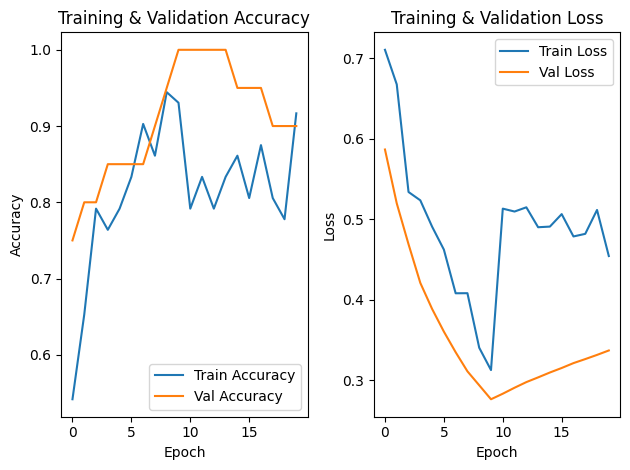

In [14]:
# Combine training histories
acc = history1.history['accuracy'] + history2.history['accuracy']
val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
loss = history1.history['loss'] + history2.history['loss']
val_loss = history1.history['val_loss'] + history2.history['val_loss']

plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted class: rural


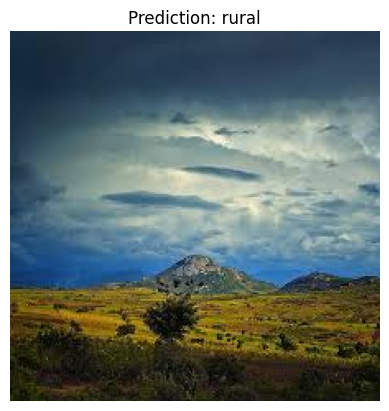

In [15]:
# --- Predict on a Sample Image ---
img_path = os.path.join(train_dir, 'rural', 'rural1.jpeg')  # Replace if needed
img = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

prediction = model.predict(img_array)[0][0]
predicted_class = 'urban' if prediction >= 0.5 else 'rural'

print(f"Predicted class: {predicted_class}")

plt.imshow(load_img(img_path))
plt.title(f"Prediction: {predicted_class}")
plt.axis('off')
plt.show()